In [17]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# SPES Exploration
This is a Single Pulse exploration notebook. The goal here is interact with basic I/O for SPES data and prototype some methods for CRP parameterization 

In [78]:
# Basic viz
DATA_FOLDER = '/mnt/ernie_main/000_Data/SPES/data/preprocessed/'
file = 'Epat26/Epat26_CCEP_single_pulses/Epat26_LA1-LA2_5mA_pulse_1.mat'
spes_trial = loadmat(os.path.join(DATA_FOLDER, file))


In [79]:
spes_trial.keys()
hdr = spes_trial['__header__']
fs = spes_trial['fs'][0][0]
full_train = spes_trial["pulse"]
labels  = [l[0] for l in spes_trial['labels'][0]]
print(f"train datashape: {full_train.shape}, sampled at {fs}")
print(f"First 10 labels: {labels[0:10]} \n\n there are {len(labels)} total labels")

spes_df = construct_spes_df(full_train, labels, fs)

train datashape: (148, 487), sampled at 512
First 10 labels: ['LTP1', 'LTP2', 'LTP3', 'LTP4', 'LTP5', 'LTP6', 'LTP7', 'LTP8', 'LTP9', 'LTP10'] 

 there are 148 total labels


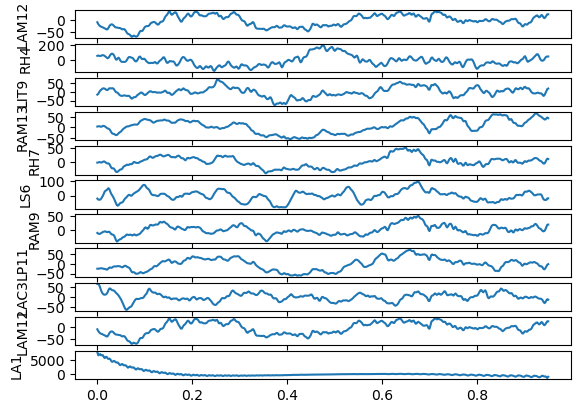

In [81]:
spes_df
rind10 = np.random.random_integers(0,len(labels)-1,10)
chs_to_plot = list(spes_df.columns[rind10])
if "LA1" not in chs_to_plot:
    chs_to_plot.append("LA1")
plot_channels(spes_df, chs_to_plot)

In [82]:
t_ix = lambda t: round(t*fs)
s = t_ix(.01)
s

5

<Axes: >

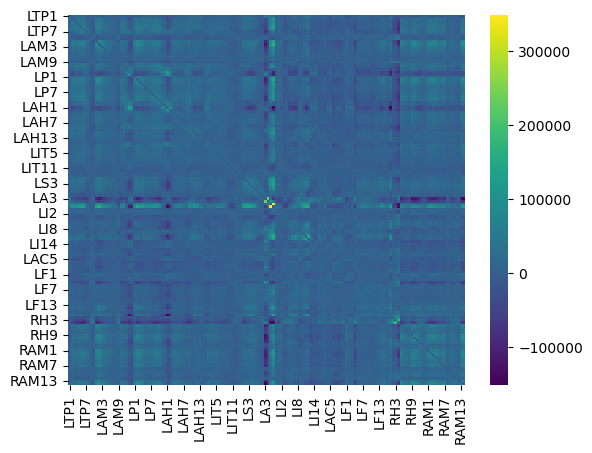

In [83]:
#TODO need to incorporate artifact removal and then work on cross projection. 
#For now, it would be interesting to get global cross projection

resp_inds = np.where( "LA2" != np.array(labels))
other_inds = np.where("LA1" != np.array(labels))
resp_inds = np.intersect1d(resp_inds,other_inds)
resp_labels = np.array(labels)[resp_inds]

resp_areas = spes_df[spes_df.columns[ resp_inds]].values
resp_areas = resp_areas[t_ix(.1):t_ix(.25)]
full_crossproj = resp_areas.T@resp_areas
full_crossproj = full_crossproj - np.diag(full_crossproj)*np.identity(146)
df_full_crossproj = pd.DataFrame(data=full_crossproj, columns=resp_labels, index=resp_labels)
sns.heatmap(df_full_crossproj, cmap="viridis")


In [91]:
norm[0:3]

array([525.33844582, 533.89797366, 621.94122583])

In [89]:
resp_areas = spes_df[spes_df.columns[ resp_inds]].values
norm = np.linalg.norm(resp_areas,axis=1)
V_norm =resp_areas/ norm[:,None]

In [95]:
V_norm.shape

(487, 146)

In [94]:
s = t_ix(.025)
cross_dfs = []
#TODO consider adding area relationships
for t in np.linspace(0.05, 0.99,50):
    e = t_ix(t)
    win_len = t - .025
    V = V_norm[s:e]
    V_raw = resp_areas[s:e]
    full_crossproj = V.T@V_raw
    full_crossproj = full_crossproj - np.diag(full_crossproj)*np.identity(146)
    df = pd.DataFrame(data=full_crossproj.flatten(), columns=['cross_proj'])
    df['win_size'] = win_len
    cross_dfs.append(df)
cross_proj_df = pd.concat(cross_dfs)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 0 is different from 22)

<Axes: xlabel='win_size', ylabel='cross_proj'>

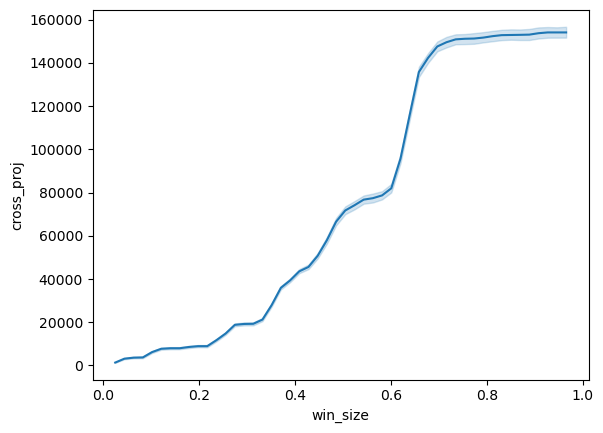

In [85]:
sns.lineplot(data=cross_proj_df, x="win_size", y="cross_proj")

In [4]:
def construct_spes_df(spes_trains, contact_labels, fs):
    assert len(contact_labels) == min(spes_trains.shape)
    if np.argmax(spes_trains.shape) != 0:
        spes_trains = spes_trains.T
    nsamps,ch = spes_trains.shape
    t = np.arange(nsamps)/fs
    df = pd.DataFrame(columns=contact_labels, index =t, data=spes_trains)
    return  df

def plot_channels(spes_df , channel_list):
    nrows = len(channel_list)
    fig, axes = plt.subplots(nrows=nrows, ncols=1,sharex=True)
    for i,ch in enumerate(channel_list):
        ax = axes[i]
        sns.lineplot(x=spes_df.index, y=spes_df[ch], ax=ax)
    
    